# Breakeven Calculator for Options Strategies

This notebook will help us calculate breakeven points for various option strategies.
We'll start with simple single-leg strategies and gradually move to complex multi-leg strategies.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple, Optional
import requests
import json

## Test 1: Single Leg Strategy Breakeven Calculator

### Input Parameters:
- **Action**: BUY or SELL
- **Index**: NIFTY (for now)
- **Expiry Date**: e.g., '26-Jun-2025'
- **Strike**: Strike price
- **Option Type**: CE or PE
- **Quantity**: Number of lots (75 = 1 lot for NIFTY)
- **Price**: Premium per unit

### Breakeven Logic:
- **Buy Call (CE)**: Breakeven = Strike + Premium
- **Sell Call (CE)**: Breakeven = Strike + Premium
- **Buy Put (PE)**: Breakeven = Strike - Premium
- **Sell Put (PE)**: Breakeven = Strike - Premium

In [2]:
class OptionLeg:
    """
    Represents a single option leg in a strategy.
    """
    def __init__(self, action: str, option_type: str, strike: float, premium: float, quantity: int = 75):
        """
        Args:
            action: 'BUY' or 'SELL'
            option_type: 'CE' or 'PE'
            strike: Strike price
            premium: Premium per unit
            quantity: Number of shares/units (default 75 for 1 NIFTY lot)
        """
        self.action = action.upper()
        self.option_type = option_type.upper()
        self.strike = float(strike)
        self.premium = float(premium)
        self.quantity = int(quantity)
        
        # Action multiplier: +1 for BUY, -1 for SELL
        self.action_multiplier = 1 if self.action == 'BUY' else -1
        
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate the payoff at expiry for a given spot price.
        """
        if self.option_type == 'CE':
            # Call option payoff
            intrinsic_value = max(0, spot_price - self.strike)
        else:  # PE
            # Put option payoff
            intrinsic_value = max(0, self.strike - spot_price)
        
        # Position payoff = action_multiplier * intrinsic_value * quantity
        position_payoff = self.action_multiplier * intrinsic_value * self.quantity
        
        # Premium effect: BUY means premium paid (negative), SELL means premium received (positive)
        premium_effect = -self.action_multiplier * self.premium * self.quantity
        
        return position_payoff + premium_effect
    
    def __str__(self):
        return f"{self.action} {self.strike} {self.option_type} @ ₹{self.premium} (Qty: {self.quantity})"

In [3]:
def calculate_single_leg_breakeven(leg: OptionLeg) -> float:
    """
    Calculate breakeven point for a single option leg.
    """
    if leg.option_type == 'CE':
        # For Call options: Breakeven = Strike ± Premium
        if leg.action == 'BUY':
            breakeven = leg.strike + leg.premium
        else:  # SELL
            breakeven = leg.strike + leg.premium
    else:  # PE
        # For Put options: Breakeven = Strike ± Premium
        if leg.action == 'BUY':
            breakeven = leg.strike - leg.premium
        else:  # SELL
            breakeven = leg.strike - leg.premium
    
    return breakeven

In [4]:
def plot_payoff_diagram(legs: List[OptionLeg], title: str = "Payoff Diagram"):
    """
    Plot the payoff diagram for the given option legs.
    """
    # Determine spot price range
    strikes = [leg.strike for leg in legs]
    min_strike = min(strikes)
    max_strike = max(strikes)
    
    # Create spot price range (±20% around strikes)
    spot_range = np.linspace(min_strike * 0.8, max_strike * 1.2, 200)
    
    # Calculate total payoff for each spot price
    total_payoffs = []
    for spot in spot_range:
        total_payoff = sum(leg.payoff_at_expiry(spot) for leg in legs)
        total_payoffs.append(total_payoff)
    
    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(spot_range, total_payoffs, 'b-', linewidth=2)
    plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
    plt.axvline(x=min_strike, color='r', linestyle='--', alpha=0.3, label='Strike Prices')
    if len(strikes) > 1:
        for strike in strikes[1:]:
            plt.axvline(x=strike, color='r', linestyle='--', alpha=0.3)
    
    plt.xlabel('Spot Price at Expiry')
    plt.ylabel('Profit/Loss (₹)')
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.show()
    
    return spot_range, total_payoffs

## 2. Sell Call (Short Call)

**Market View**: Bearish to Neutral - You expect the underlying to stay below the strike price or decline.

**Trade Structure**: 
- Sell 1 Call option at strike price K
- Receive premium P upfront

**Breakeven Logic**: 
- Breakeven = Strike Price + Premium Received
- Above breakeven: Loss increases as underlying rises
- Below breakeven: Keep the premium (profit)

**Max Profit**: Limited to Premium Received (when underlying ≤ Strike at expiry)

**Max Loss**: Unlimited (as underlying can rise indefinitely above strike)

**Premium Flow**: Credit strategy - you receive premium upfront

**Example**: Sell NIFTY 10th Jul 25450 CE @ ₹150.5, Qty: 75
- Strike: 25450, Premium Received: ₹150.5 per unit
- Breakeven: 25450 + 150.5 = 25600.5
- Max Profit: ₹150.5 × 75 = ₹11,287.5
- Max Loss: Unlimited (if NIFTY rises significantly above 25600.5)

In [48]:
class SellCall:
    """
    Short Call Option Strategy
    - Sell 1 Call option
    - Bearish to neutral market view
    - Unlimited loss potential, limited profit
    """
    
    def __init__(self, strike: float, premium: float, quantity: int = 75):
        self.strike = strike
        self.premium = premium
        self.quantity = quantity
        
        # Create the option leg using correct OptionLeg constructor
        self.call_leg = OptionLeg('SELL', 'CE', strike, premium, quantity)
    
    def calculate_breakeven(self) -> float:
        """Calculate breakeven point for sell call"""
        return self.strike + self.premium
    
    def calculate_max_profit(self) -> float:
        """Calculate maximum profit (premium received)"""
        return self.premium * self.quantity
    
    def calculate_max_loss(self) -> str:
        """Maximum loss is unlimited"""
        return "Unlimited"
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """Calculate total payoff at expiry for given spot price"""
        return self.call_leg.payoff_at_expiry(spot_price)
    
    def analyze_strategy(self) -> Dict:
        """Comprehensive analysis of the sell call strategy"""
        breakeven = self.calculate_breakeven()
        max_profit = self.calculate_max_profit()
        max_loss = self.calculate_max_loss()
        
        # Calculate payoffs at key levels
        payoff_at_strike = self.payoff_at_expiry(self.strike)
        payoff_at_breakeven = self.payoff_at_expiry(breakeven)
        payoff_below_strike = self.payoff_at_expiry(self.strike - 100)
        payoff_above_breakeven = self.payoff_at_expiry(breakeven + 100)
        
        return {
            'strategy': 'Sell Call',
            'market_view': 'Bearish to Neutral',
            'breakeven': breakeven,
            'max_profit': max_profit,
            'max_loss': max_loss,
            'strike': self.strike,
            'premium_received': self.premium,
            'quantity': self.quantity,
            'payoff_at_strike': payoff_at_strike,
            'payoff_at_breakeven': payoff_at_breakeven,
            'payoff_below_strike': payoff_below_strike,
            'payoff_above_breakeven': payoff_above_breakeven
        }
    
    def __str__(self):
        return (f"Sell Call: "
                f"SELL {self.strike} CE @ ₹{self.premium} "
                f"(Qty: {self.quantity})")

def analyze_sell_call(strike: float, premium: float, quantity: int = 75):
    """Analyze a sell call strategy and print key metrics"""
    strategy = SellCall(strike, premium, quantity)
    analysis = strategy.analyze_strategy()
    
    print(f"=== {analysis['strategy']} Analysis ===")
    print(f"Market View: {analysis['market_view']}")
    print(f"Strike Price: ₹{analysis['strike']}")
    print(f"Premium Received: ₹{analysis['premium_received']} per unit")
    print(f"Quantity: {analysis['quantity']} units")
    print(f"Total Premium Received: ₹{analysis['max_profit']}")
    print()
    print(f"Breakeven Point: ₹{analysis['breakeven']}")
    print(f"Maximum Profit: ₹{analysis['max_profit']} (when spot ≤ ₹{analysis['strike']})")
    print(f"Maximum Loss: {analysis['max_loss']}")
    print()
    print("Payoff Analysis:")
    print(f"  At Strike (₹{analysis['strike']}): ₹{analysis['payoff_at_strike']}")
    print(f"  At Breakeven (₹{analysis['breakeven']}): ₹{analysis['payoff_at_breakeven']}")
    print(f"  Below Strike (₹{analysis['strike'] - 100}): ₹{analysis['payoff_below_strike']}")
    print(f"  Above Breakeven (₹{analysis['breakeven'] + 100}): ₹{analysis['payoff_above_breakeven']}")
    print()
    return strategy

In [50]:
# Example: Sell NIFTY 10th Jul 25450 CE @ ₹150.5, Qty: 75
print("Example: Sell NIFTY 25450 CE @ ₹150.5, Quantity: 75")
print("=" * 50)

sell_call_strategy = analyze_sell_call(
    strike=25400,
    premium=178.85,
    quantity=75
)

print("\nKey Risk Points:")
print("- Unlimited loss potential if NIFTY rises significantly above breakeven")
print("- Maximum profit achieved if NIFTY stays at or below ₹25450 at expiry")
print("- Time decay works in favor of the seller")
print("- Requires margin for unlimited risk exposure")

Example: Sell NIFTY 25450 CE @ ₹150.5, Quantity: 75
=== Sell Call Analysis ===
Market View: Bearish to Neutral
Strike Price: ₹25400
Premium Received: ₹178.85 per unit
Quantity: 75 units
Total Premium Received: ₹13413.75

Breakeven Point: ₹25578.85
Maximum Profit: ₹13413.75 (when spot ≤ ₹25400)
Maximum Loss: Unlimited

Payoff Analysis:
  At Strike (₹25400): ₹13413.75
  At Breakeven (₹25578.85): ₹1.0913936421275139e-10
  Below Strike (₹25300): ₹13413.75
  Above Breakeven (₹25678.85): ₹-7499.999999999891


Key Risk Points:
- Unlimited loss potential if NIFTY rises significantly above breakeven
- Maximum profit achieved if NIFTY stays at or below ₹25450 at expiry
- Time decay works in favor of the seller
- Requires margin for unlimited risk exposure


## Example 1: Buy Call Option

Let's test with the example from your image:
- **BUY NIFTY 10th Jul 25450 CE**
- **Qty: 75** (1 lot)
- **Price: ₹150.5**

In [10]:
# Test 1: Buy Call Example
leg1 = OptionLeg(
    action='BUY',
    option_type='CE',
    strike=25550,
    premium=103.1,
    quantity=75
)

print(f"Position: {leg1}")
print(f"Total Premium Paid: ₹{leg1.premium * leg1.quantity:,.2f}")

# Calculate breakeven
breakeven = calculate_single_leg_breakeven(leg1)
print(f"\nBreakeven Point: ₹{breakeven:,.2f}")

# Test payoff at different spot prices
test_spots = [25000, 25450, 25600, 25461]
print("\nPayoff at different spot prices:")
for spot in test_spots:
    payoff = leg1.payoff_at_expiry(spot)
    print(f"Spot: ₹{spot:,} → P&L: ₹{payoff:,.2f}")

Position: BUY 25550.0 CE @ ₹103.1 (Qty: 75)
Total Premium Paid: ₹7,732.50

Breakeven Point: ₹25,653.10

Payoff at different spot prices:
Spot: ₹25,000 → P&L: ₹-7,732.50
Spot: ₹25,450 → P&L: ₹-7,732.50
Spot: ₹25,600 → P&L: ₹-3,982.50
Spot: ₹25,461 → P&L: ₹-7,732.50


In [ ]:
# Plot payoff diagram for the Buy Call
spot_range, payoffs = plot_payoff_diagram([leg1], "Buy Call - NIFTY 25450 CE")

# Mark breakeven point on the plot
plt.figure(figsize=(12, 6))
plt.plot(spot_range, payoffs, 'b-', linewidth=2, label='P&L')
plt.axhline(y=0, color='k', linestyle='--', alpha=0.3)
plt.axvline(x=leg1.strike, color='r', linestyle='--', alpha=0.5, label=f'Strike: {leg1.strike}')
plt.axvline(x=breakeven, color='g', linestyle='-', alpha=0.7, label=f'Breakeven: {breakeven:.2f}')
plt.xlabel('Spot Price at Expiry')
plt.ylabel('Profit/Loss (₹)')
plt.title('Buy Call - NIFTY 25450 CE @ ₹150.5')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## Test Cases for Different Single Leg Strategies

In [18]:
# Test Case 1: Buy Call
print("Test Case 1: Buy Call")
buy_call = OptionLeg('BUY', 'CE', 25550, 103.1, 75)
be1 = calculate_single_leg_breakeven(buy_call)
print(f"{buy_call} → Breakeven: ₹{be1:,.2f}")
payoff1 = buy_call.payoff_at_expiry(25461)
print(f"Payoff at Spot ₹25461: ₹{payoff1:,.2f}")
print()

# Test Case 2: Sell Call
print("Test Case 2: Sell Call")
sell_call = OptionLeg('SELL', 'PE', 25200, 45.2, 75)
be2 = calculate_single_leg_breakeven(sell_call)
print(f"{sell_call} → Breakeven: ₹{be2:,.2f}")
payoff2 = sell_call.payoff_at_expiry(25461)
print(f"Payoff at Spot ₹25461: ₹{payoff2:,.2f}")
print()


# Test Case 3: Buy Put
print("Test Case 3: Buy Put")
buy_put = OptionLeg('BUY', 'PE', 25300, 67.45, 75)
be3 = calculate_single_leg_breakeven(buy_put)
print(f"{buy_put} → Breakeven: ₹{be3:,.2f}")
payoff3 = buy_put.payoff_at_expiry(25461)
print(f"Payoff at Spot ₹25461: ₹{payoff3:,.2f}")
print()

# Test Case 4: Sell Put
print("Test Case 4: Sell Put")
sell_put = OptionLeg('SELL', 'CE', 25700, 54.75, 75)
be4 = calculate_single_leg_breakeven(sell_put)
print(f"{sell_put} → Breakeven: ₹{be4:,.2f}")
payoff4 = sell_put.payoff_at_expiry(25461)
print(f"Payoff at Spot ₹25461: ₹{payoff4:,.2f}")


Test Case 1: Buy Call
BUY 25550.0 CE @ ₹103.1 (Qty: 75) → Breakeven: ₹25,653.10
Payoff at Spot ₹25461: ₹-7,732.50

Test Case 2: Sell Call
SELL 25200.0 PE @ ₹45.2 (Qty: 75) → Breakeven: ₹25,154.80
Payoff at Spot ₹25461: ₹3,390.00

Test Case 3: Buy Put
BUY 25300.0 PE @ ₹67.45 (Qty: 75) → Breakeven: ₹25,232.55
Payoff at Spot ₹25461: ₹-5,058.75

Test Case 4: Sell Put
SELL 25700.0 CE @ ₹54.75 (Qty: 75) → Breakeven: ₹25,754.75
Payoff at Spot ₹25461: ₹4,106.25


## Multi-Leg Strategies: Bull Call Spread

### Bull Call Spread Strategy
- **Market View**: Moderately Bullish
- **The Trade**: 
  - Buy a call option (lower strike, near current price)
  - Sell a call option (higher strike, same expiry)
  - Net premium is paid (buy premium > sell premium)

### Key Metrics:
- **Breakeven**: Strike price of bought option + Net Premium Paid
- **Max Profit**: Higher Strike - Lower Strike - Net Premium Paid
- **Max Loss**: Net Premium Paid

### Example from your image:
- **BUY NIFTY 10th Jul 25450 CE @ ₹150.5**
- **SELL NIFTY 10th Jul 25650 CE @ ₹68.1**
- **Net Premium**: 150.5 - 68.1 = ₹82.4 per share

In [23]:
class BullCallSpread:
    """
    Represents a Bull Call Spread strategy.
    """
    def __init__(self, buy_strike: float, buy_premium: float, 
                 sell_strike: float, sell_premium: float, quantity: int = 75):
        """
        Args:
            buy_strike: Strike price of the call option to buy (lower strike)
            buy_premium: Premium of the call option to buy
            sell_strike: Strike price of the call option to sell (higher strike)
            sell_premium: Premium of the call option to sell
            quantity: Number of shares/units per leg
        """
        self.buy_leg = OptionLeg('BUY', 'CE', buy_strike, buy_premium, quantity)
        self.sell_leg = OptionLeg('SELL', 'CE', sell_strike, sell_premium, quantity)
        
        # Validate that buy_strike < sell_strike
        if buy_strike >= sell_strike:
            raise ValueError("Buy strike must be lower than sell strike for Bull Call Spread")
        
        self.net_premium = buy_premium - sell_premium  # Net premium paid
        self.quantity = quantity
        
    def calculate_breakeven(self) -> float:
        """
        Calculate breakeven point for Bull Call Spread.
        Breakeven = Lower Strike + Net Premium Paid
        """
        return self.buy_leg.strike + self.net_premium
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bull Call Spread.
        Max Profit = (Higher Strike - Lower Strike - Net Premium) * Quantity
        """
        spread_width = self.sell_leg.strike - self.buy_leg.strike
        max_profit_per_unit = spread_width - self.net_premium
        return max_profit_per_unit * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bull Call Spread.
        Max Loss = Net Premium Paid * Quantity
        """
        return self.net_premium * self.quantity
    
    spot_price = 25461
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        buy_payoff = self.buy_leg.payoff_at_expiry(spot_price)
        sell_payoff = self.sell_leg.payoff_at_expiry(spot_price)
        return buy_payoff + sell_payoff
    
    def __str__(self):
        return (f"Bull Call Spread: "
                f"BUY {self.buy_leg.strike} CE @ ₹{self.buy_leg.premium}, "
                f"SELL {self.sell_leg.strike} CE @ ₹{self.sell_leg.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bull_call_spread(spread: BullCallSpread):
    """
    Comprehensive analysis of a Bull Call Spread strategy.
    """
    print(f"Strategy: {spread}")
    print(f"Quantity: {spread.quantity} units per leg")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Paid: ₹{spread.net_premium:.2f} per unit")
    print(f"Total Premium Paid: ₹{spread.calculate_max_loss():,.2f}")
    print(f"Breakeven Point: ₹{spread.calculate_breakeven():,.2f}")
    print(f"Maximum Profit: ₹{spread.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{spread.calculate_max_loss():,.2f}")
    
    # Test payoffs at key levels
    key_levels = [
        spread.buy_leg.strike - 100,    # Below lower strike
        spread.buy_leg.strike,          # At lower strike  
        spread.calculate_breakeven(),   # At breakeven
        spread.sell_leg.strike,         # At higher strike
        spread.sell_leg.strike + 100    # Above higher strike
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = spread.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return spread

In [75]:
# Example: Bull Call Spread from your image
print("🚀 Bull Call Spread Example:")
print("=" * 50)

# Create the Bull Call Spread strategy
bull_call_spread = BullCallSpread(
    buy_strike=25500,   # BUY 25450 CE
    buy_premium=100.1,  # @ ₹150.5
    sell_strike=25600 ,  # SELL 25650 CE  
    sell_premium=61.9,  # @ ₹68.1
    quantity=75         # 1 lot = 75 units
)

# Analyze the strategy
analyze_bull_call_spread(bull_call_spread)

🚀 Bull Call Spread Example:
Strategy: Bull Call Spread: BUY 25500.0 CE @ ₹100.1, SELL 25600.0 CE @ ₹61.9 (Net Premium: ₹38.20)
Quantity: 75 units per leg

📊 Key Metrics:
Net Premium Paid: ₹38.20 per unit
Total Premium Paid: ₹2,865.00
Breakeven Point: ₹25,538.20
Maximum Profit: ₹4,635.00
Maximum Loss: ₹2,865.00

💰 Payoff at Key Levels:
Spot ₹25,400.00: P&L ₹-2,865.00
Spot ₹25,500.00: P&L ₹-2,865.00
Spot ₹25,538.20: P&L ₹0.00
Spot ₹25,600.00: P&L ₹4,635.00
Spot ₹25,700.00: P&L ₹4,635.00


## Bull Put Spread Strategy

### Market View
**Mildly Bullish** - Trade when you expect the underlying to not go down (stay stable, go up, or even go down slightly)

### The Trade
- **Sell a Put** option with strike near or below stock price (higher strike)
- **Buy a Put** option with lower strike (protection against big down moves)
- Both options have same expiry
- **Net Premium Received** (sell premium > buy premium)

### Key Metrics:
- **Breakeven**: Strike price of sold option - Net Premium Received
- **Max Profit**: Net Premium Received
- **Max Loss**: Higher Strike - Lower Strike - Net Premium Received

### Example from your image:
- **SELL NIFTY 10th Jul 25450 PE @ ₹122.8**
- **BUY NIFTY 10th Jul 25250 PE @ ₹55.6**
- **Net Premium Received**: 122.8 - 55.6 = ₹67.2 per share

In [29]:
class BullPutSpread:
    """
    Represents a Bull Put Spread strategy.
    """
    def __init__(self, sell_strike: float, sell_premium: float, 
                 buy_strike: float, buy_premium: float, quantity: int = 75):
        """
        Args:
            sell_strike: Strike price of the put option to sell (higher strike)
            sell_premium: Premium of the put option to sell
            buy_strike: Strike price of the put option to buy (lower strike)
            buy_premium: Premium of the put option to buy
            quantity: Number of shares/units per leg
        """
        self.sell_leg = OptionLeg('SELL', 'PE', sell_strike, sell_premium, quantity)
        self.buy_leg = OptionLeg('BUY', 'PE', buy_strike, buy_premium, quantity)
        
        # Validate that sell_strike > buy_strike
        if sell_strike <= buy_strike:
            raise ValueError("Sell strike must be higher than buy strike for Bull Put Spread")
        
        self.net_premium = sell_premium - buy_premium  # Net premium received
        self.quantity = quantity
        
    def calculate_breakeven(self) -> float:
        """
        Calculate breakeven point for Bull Put Spread.
        Breakeven = Sell Strike - Net Premium Received
        """
        return self.sell_leg.strike - self.net_premium
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bull Put Spread.
        Max Profit = Net Premium Received * Quantity
        """
        return self.net_premium * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bull Put Spread.
        Max Loss = (Higher Strike - Lower Strike - Net Premium Received) * Quantity
        """
        spread_width = self.sell_leg.strike - self.buy_leg.strike
        max_loss_per_unit = spread_width - self.net_premium
        return max_loss_per_unit * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        sell_payoff = self.sell_leg.payoff_at_expiry(spot_price)
        buy_payoff = self.buy_leg.payoff_at_expiry(spot_price)
        return sell_payoff + buy_payoff
    
    def __str__(self):
        return (f"Bull Put Spread: "
                f"SELL {self.sell_leg.strike} PE @ ₹{self.sell_leg.premium}, "
                f"BUY {self.buy_leg.strike} PE @ ₹{self.buy_leg.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bull_put_spread(spread: BullPutSpread):
    """
    Comprehensive analysis of a Bull Put Spread strategy.
    """
    print(f"Strategy: {spread}")
    print(f"Quantity: {spread.quantity} units per leg")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Received: ₹{spread.net_premium:.2f} per unit")
    print(f"Total Premium Received: ₹{spread.calculate_max_profit():,.2f}")
    print(f"Breakeven Point: ₹{spread.calculate_breakeven():,.2f}")
    print(f"Maximum Profit: ₹{spread.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{spread.calculate_max_loss():,.2f}")
    
    # Test payoffs at key levels
    key_levels = [
        spread.buy_leg.strike - 100,    # Below lower strike
        spread.buy_leg.strike,          # At lower strike (buy)
        spread.calculate_breakeven(),   # At breakeven
        spread.sell_leg.strike,         # At higher strike (sell)
        spread.sell_leg.strike + 100    # Above higher strike
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = spread.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return spread

In [31]:
# Example: Bull Put Spread from your image
print("🐂 Bull Put Spread Example:")
print("=" * 50)

# Create the Bull Put Spread strategy
bull_put_spread = BullPutSpread(
    sell_strike=25400,  # SELL 25450 PE
    sell_premium=101.2, # @ ₹122.8
    buy_strike=25350,   # BUY 25250 PE
    buy_premium=83.35,   # @ ₹55.6
    quantity=75         # 1 lot = 75 units
)

# Analyze the strategy
analyze_bull_put_spread(bull_put_spread)

🐂 Bull Put Spread Example:
Strategy: Bull Put Spread: SELL 25400.0 PE @ ₹101.2, BUY 25350.0 PE @ ₹83.35 (Net Premium: ₹17.85)
Quantity: 75 units per leg

📊 Key Metrics:
Net Premium Received: ₹17.85 per unit
Total Premium Received: ₹1,338.75
Breakeven Point: ₹25,382.15
Maximum Profit: ₹1,338.75
Maximum Loss: ₹2,411.25

💰 Payoff at Key Levels:
Spot ₹25,250.00: P&L ₹-2,411.25
Spot ₹25,350.00: P&L ₹-2,411.25
Spot ₹25,382.15: P&L ₹0.00
Spot ₹25,400.00: P&L ₹1,338.75
Spot ₹25,500.00: P&L ₹1,338.75


## Call Ratio Back Spread Strategy

### Market View
**Very Bullish** - Trade when expecting a strong upward move in the underlying stock/index

### The Trade
- **Sell 1 Call** option at lower strike (near or below current price)
- **Buy 2 Call** options at higher strike (above current price)
- Both options have same expiry
- **Premium**: Can be paid, received, or zero cost depending on strikes and premiums

### Key Metrics:
**If Premium Received:**
- **Lower Breakeven**: Lower Strike + Net Premium Received
- **Upper Breakeven**: Higher Strike + (Higher Strike - Lower Strike) - Net Premium Received
- **Max Loss**: Higher Strike - Lower Strike - Net Premium Received

**If Premium Paid:**
- **Breakeven**: Higher Strike + (Higher Strike - Lower Strike) + Net Premium Paid
- **Max Loss**: Higher Strike - Lower Strike + Net Premium Paid

**Always:**
- **Max Profit**: Unlimited (above upper breakeven)

### Example from your image:
- **SELL NIFTY 10th Jul 25450 CE @ ₹150.5 (Qty: 75)**
- **BUY NIFTY 10th Jul 25650 CE @ ₹68.1 (Qty: 150)**
- **Net Premium**: (68.1 × 2) - 150.5 = -₹14.3 per unit (Premium Paid)

In [32]:
class CallRatioBackSpread:
    """
    Represents a Call Ratio Back Spread strategy.
    Sell 1 call (lower strike) + Buy 2 calls (higher strike)
    """
    def __init__(self, sell_strike: float, sell_premium: float, 
                 buy_strike: float, buy_premium: float, quantity: int = 75):
        """
        Args:
            sell_strike: Strike price of the call option to sell (lower strike)
            sell_premium: Premium of the call option to sell
            buy_strike: Strike price of the call option to buy (higher strike)
            buy_premium: Premium of the call option to buy
            quantity: Base quantity (sell quantity = quantity, buy quantity = 2 * quantity)
        """
        # Sell 1 call at lower strike
        self.sell_leg = OptionLeg('SELL', 'CE', sell_strike, sell_premium, quantity)
        # Buy 2 calls at higher strike
        self.buy_leg = OptionLeg('BUY', 'CE', buy_strike, buy_premium, quantity * 2)
        
        # Validate that sell_strike < buy_strike
        if sell_strike >= buy_strike:
            raise ValueError("Sell strike must be lower than buy strike for Call Ratio Back Spread")
        
        # Net premium calculation: (2 * buy_premium) - sell_premium
        self.net_premium = (2 * buy_premium) - sell_premium
        self.quantity = quantity
        self.is_premium_paid = self.net_premium > 0
        
    def calculate_breakeven(self) -> Tuple[Optional[float], Optional[float]]:
        """
        Calculate breakeven points for Call Ratio Back Spread.
        Returns tuple: (lower_breakeven, upper_breakeven)
        """
        spread_width = self.buy_leg.strike - self.sell_leg.strike
        
        if self.is_premium_paid:
            # Premium Paid case - only one breakeven point
            upper_breakeven = self.buy_leg.strike + spread_width + self.net_premium
            return (None, upper_breakeven)
        else:
            # Premium Received case - two breakeven points
            lower_breakeven = self.sell_leg.strike + abs(self.net_premium)
            upper_breakeven = self.buy_leg.strike + spread_width - abs(self.net_premium)
            return (lower_breakeven, upper_breakeven)
    
    def calculate_max_profit(self) -> str:
        """
        Calculate maximum profit for Call Ratio Back Spread.
        """
        return "Unlimited (above upper breakeven)"
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Call Ratio Back Spread.
        """
        spread_width = self.buy_leg.strike - self.sell_leg.strike
        
        if self.is_premium_paid:
            max_loss_per_unit = spread_width + self.net_premium
        else:
            max_loss_per_unit = spread_width - abs(self.net_premium)
        
        return max_loss_per_unit * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        sell_payoff = self.sell_leg.payoff_at_expiry(spot_price)
        buy_payoff = self.buy_leg.payoff_at_expiry(spot_price)
        return sell_payoff + buy_payoff
    
    def __str__(self):
        premium_status = "Paid" if self.is_premium_paid else "Received"
        return (f"Call Ratio Back Spread: "
                f"SELL {self.sell_leg.strike} CE @ ₹{self.sell_leg.premium}, "
                f"BUY 2x {self.buy_leg.strike} CE @ ₹{self.buy_leg.premium/2} "
                f"(Net Premium {premium_status}: ₹{abs(self.net_premium):.2f})")


def analyze_call_ratio_back_spread(spread: CallRatioBackSpread):
    """
    Comprehensive analysis of a Call Ratio Back Spread strategy.
    """
    print(f"Strategy: {spread}")
    print(f"Base Quantity: {spread.quantity} units (Sell: {spread.quantity}, Buy: {spread.quantity * 2})")
    
    premium_status = "Paid" if spread.is_premium_paid else "Received"
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium {premium_status}: ₹{abs(spread.net_premium):.2f} per unit")
    print(f"Total Premium {premium_status}: ₹{abs(spread.net_premium * spread.quantity):,.2f}")
    
    # Get breakeven points
    lower_be, upper_be = spread.calculate_breakeven()
    
    if spread.is_premium_paid:
        print(f"Breakeven Point: ₹{upper_be:,.2f}")
    else:
        print(f"Lower Breakeven: ₹{lower_be:,.2f}")
        print(f"Upper Breakeven: ₹{upper_be:,.2f}")
    
    print(f"Maximum Profit: {spread.calculate_max_profit()}")
    print(f"Maximum Loss: ₹{spread.calculate_max_loss():,.2f}")
    
    # Test payoffs at key levels
    key_levels = [
        spread.sell_leg.strike - 100,   # Below sell strike
        spread.sell_leg.strike,         # At sell strike
        spread.buy_leg.strike,          # At buy strike
    ]
    
    # Add breakeven points to test levels
    if lower_be:
        key_levels.append(lower_be)
    if upper_be:
        key_levels.append(upper_be)
    
    key_levels.append(spread.buy_leg.strike + 200)  # Well above buy strike
    key_levels.sort()
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = spread.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return spread

In [34]:
# Example: Call Ratio Back Spread from your image
print("📈 Call Ratio Back Spread Example:")
print("=" * 50)

# Create the Call Ratio Back Spread strategy
call_ratio_back_spread = CallRatioBackSpread(
    sell_strike=25600,  # SELL 25450 CE
    sell_premium=84.9, # @ ₹150.5
    buy_strike=25700,   # BUY 25650 CE (2x quantity)
    buy_premium=54.75,   # @ ₹68.1
    quantity=75         # Base quantity: Sell 75, Buy 150
)

# Analyze the strategy
analyze_call_ratio_back_spread(call_ratio_back_spread)

📈 Call Ratio Back Spread Example:
Strategy: Call Ratio Back Spread: SELL 25600.0 CE @ ₹84.9, BUY 2x 25700.0 CE @ ₹27.375 (Net Premium Paid: ₹24.60)
Base Quantity: 75 units (Sell: 75, Buy: 150)

📊 Key Metrics:
Net Premium Paid: ₹24.60 per unit
Total Premium Paid: ₹1,845.00
Breakeven Point: ₹25,824.60
Maximum Profit: Unlimited (above upper breakeven)
Maximum Loss: ₹9,345.00

💰 Payoff at Key Levels:
Spot ₹25,500.00: P&L ₹-1,845.00
Spot ₹25,600.00: P&L ₹-1,845.00
Spot ₹25,700.00: P&L ₹-9,345.00
Spot ₹25,824.60: P&L ₹-0.00
Spot ₹25,900.00: P&L ₹5,655.00


Due -> dufferent expiry || long calender with call
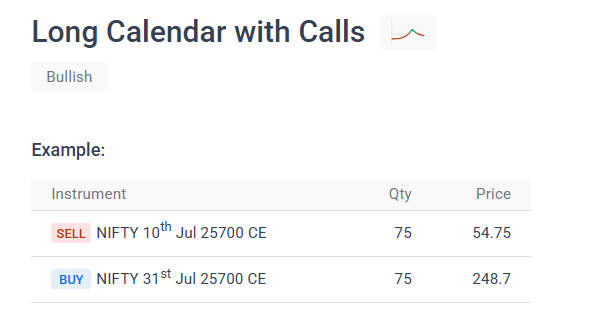

## Bull Condor Strategy

### Market View
**Bullish** - Trade when you expect the stock/index to rise and expire between the strike prices of the two sold calls, maximizing profit

### The Trade
- **Strike 1**: Buy Call slightly above the stock price
- **Strike 2**: Sell Call "N" strikes above Strike 1  
- **Strike 3**: Sell Call "N" strikes above Strike 2
- **Strike 4**: Buy Call "N" strikes above Strike 3
- All options have same expiry
- **Premium**: Usually paid, rarely received

### Key Metrics:
- **Lower Breakeven**: Strike 1 + Net Premium Paid
- **Upper Breakeven**: Strike 4 - Net Premium Paid
- **Max Profit**: Strike 2 - Strike 1 - Net Premium Paid
- **Max Loss**: Net Premium Paid

### Example from your image:
- **BUY NIFTY 10th Jul 25700 CE @ ₹54.75**
- **SELL NIFTY 10th Jul 25950 CE @ ₹16.75** 
- **SELL NIFTY 10th Jul 26200 CE @ ₹4.55**
- **BUY NIFTY 10th Jul 26450 CE @ ₹1.7**
- **Strike Intervals**: 250 points each

In [39]:
class BullCondor:
    """
    Represents a Bull Condor strategy.
    Buy Call (Strike 1) + Sell Call (Strike 2) + Sell Call (Strike 3) + Buy Call (Strike 4)
    """
    def __init__(self, buy1_strike: float, buy1_premium: float,
                 sell2_strike: float, sell2_premium: float,
                 sell3_strike: float, sell3_premium: float,
                 buy4_strike: float, buy4_premium: float, quantity: int = 75):
        """
        Args:
            buy1_strike: Strike 1 - Buy Call (lowest strike)
            buy1_premium: Premium for Strike 1
            sell2_strike: Strike 2 - Sell Call
            sell2_premium: Premium for Strike 2
            sell3_strike: Strike 3 - Sell Call
            sell3_premium: Premium for Strike 3
            buy4_strike: Strike 4 - Buy Call (highest strike)
            buy4_premium: Premium for Strike 4
            quantity: Number of units per leg
        """
        self.leg1 = OptionLeg('BUY', 'CE', buy1_strike, buy1_premium, quantity)    # Buy low
        self.leg2 = OptionLeg('SELL', 'CE', sell2_strike, sell2_premium, quantity) # Sell mid-low
        self.leg3 = OptionLeg('SELL', 'CE', sell3_strike, sell3_premium, quantity) # Sell mid-high
        self.leg4 = OptionLeg('BUY', 'CE', buy4_strike, buy4_premium, quantity*2)    # Buy high
        
        # Validate strike order
        if not (buy1_strike < sell2_strike < sell3_strike < buy4_strike):
            raise ValueError("Strikes must be in ascending order: Buy1 < Sell2 < Sell3 < Buy4")
        
        # Calculate net premium
        self.net_premium = buy1_premium + buy4_premium - sell2_premium - sell3_premium
        self.quantity = quantity
        
    def calculate_breakeven(self) -> Tuple[float, float]:
        """
        Calculate breakeven points for Bull Condor.
        Returns tuple: (lower_breakeven, upper_breakeven)
        """
        lower_breakeven = self.leg1.strike + self.net_premium
        upper_breakeven = self.leg4.strike - self.net_premium
        return (lower_breakeven, upper_breakeven)
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bull Condor.
        Max Profit = (Strike 2 - Strike 1 - Net Premium) * Quantity
        """
        profit_per_unit = self.leg2.strike - self.leg1.strike - self.net_premium
        return profit_per_unit * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bull Condor.
        Max Loss = Net Premium Paid * Quantity
        """
        return self.net_premium * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        payoff1 = self.leg1.payoff_at_expiry(spot_price)
        payoff2 = self.leg2.payoff_at_expiry(spot_price)
        payoff3 = self.leg3.payoff_at_expiry(spot_price)
        payoff4 = self.leg4.payoff_at_expiry(spot_price)
        return payoff1 + payoff2 + payoff3 + payoff4
    
    def __str__(self):
        return (f"Bull Condor: "
                f"BUY {self.leg1.strike} CE @ ₹{self.leg1.premium}, "
                f"SELL {self.leg2.strike} CE @ ₹{self.leg2.premium}, "
                f"SELL {self.leg3.strike} CE @ ₹{self.leg3.premium}, "
                f"BUY {self.leg4.strike} CE @ ₹{self.leg4.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bull_condor(condor: BullCondor):
    """
    Comprehensive analysis of a Bull Condor strategy.
    """
    print(f"Strategy: {condor}")
    print(f"Quantity: {condor.quantity} units per leg")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Paid: ₹{condor.net_premium:.2f} per unit")
    print(f"Total Premium Paid: ₹{condor.calculate_max_loss():,.2f}")
    
    # Get breakeven points
    lower_be, upper_be = condor.calculate_breakeven()
    print(f"Lower Breakeven: ₹{lower_be:,.2f}")
    print(f"Upper Breakeven: ₹{upper_be:,.2f}")
    print(f"Maximum Profit: ₹{condor.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{condor.calculate_max_loss():,.2f}")
    
    # Profit zone
    print(f"Profit Zone: Between ₹{lower_be:,.2f} and ₹{upper_be:,.2f}")
    print(f"Max Profit Zone: Between ₹{condor.leg2.strike:,.2f} and ₹{condor.leg3.strike:,.2f}")
    
    # Test payoffs at key levels
    key_levels = [
        condor.leg1.strike - 100,   # Below strike 1
        condor.leg1.strike,         # At strike 1
        lower_be,                   # Lower breakeven
        condor.leg2.strike,         # At strike 2 (max profit start)
        (condor.leg2.strike + condor.leg3.strike) / 2,  # Mid profit zone
        condor.leg3.strike,         # At strike 3 (max profit end)
        upper_be,                   # Upper breakeven
        condor.leg4.strike,         # At strike 4
        condor.leg4.strike + 100    # Above strike 4
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = condor.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return condor

In [40]:
# Example: Bull Condor from your image
print("🦅 Bull Condor Example:")
print("=" * 50)

# Create the Bull Condor strategy
bull_condor = BullCondor(
    buy1_strike=25650,   # BUY 25700 CE
    buy1_premium=68.1,  # @ ₹54.75
    sell2_strike=25900,  # SELL 25950 CE
    sell2_premium=21.1, # @ ₹16.75
    sell3_strike=26150,  # SELL 26200 CE
    sell3_premium=5.5   ,  # @ ₹4.55
    buy4_strike=26400,   # BUY 26450 CE
    buy4_premium=1.85,    # @ ₹1.7
    quantity=75          # 1 lot = 75 units
)

# Analyze the strategy
analyze_bull_condor(bull_condor)

🦅 Bull Condor Example:
Strategy: Bull Condor: BUY 25650.0 CE @ ₹68.1, SELL 25900.0 CE @ ₹21.1, SELL 26150.0 CE @ ₹5.5, BUY 26400.0 CE @ ₹1.85 (Net Premium: ₹43.35)
Quantity: 75 units per leg

📊 Key Metrics:
Net Premium Paid: ₹43.35 per unit
Total Premium Paid: ₹3,251.25
Lower Breakeven: ₹25,693.35
Upper Breakeven: ₹26,356.65
Maximum Profit: ₹15,498.75
Maximum Loss: ₹3,251.25
Profit Zone: Between ₹25,693.35 and ₹26,356.65
Max Profit Zone: Between ₹25,900.00 and ₹26,150.00

💰 Payoff at Key Levels:
Spot ₹25,550.00: P&L ₹-3,390.00
Spot ₹25,650.00: P&L ₹-3,390.00
Spot ₹25,693.35: P&L ₹-138.75
Spot ₹25,900.00: P&L ₹15,360.00
Spot ₹26,025.00: P&L ₹15,360.00
Spot ₹26,150.00: P&L ₹15,360.00
Spot ₹26,356.65: P&L ₹-138.75
Spot ₹26,400.00: P&L ₹-3,390.00
Spot ₹26,500.00: P&L ₹4,110.00


## Buy Put Strategy

### Market View
**Bearish** - Trade when you expect a big downward move in the stock/index before expiry

### The Trade
- **Simple**: Buy a put option
- Strike price is usually near or below the current stock price
- **Premium**: Pay

### Key Metrics:
- **Breakeven**: Strike Price - Premium Paid
- **Max Profit**: Unlimited (theoretically down to zero)
- **Max Loss**: Premium Paid (your maximum loss is the price you paid to buy the option)

### Example from your image:
- **BUY NIFTY 10th Jul 25450 PE @ ₹122.8**
- **Qty: 75** (1 lot)

In [41]:
class BuyPut:
    """
    Represents a Buy Put strategy.
    Simple bearish strategy - buy a put option.
    """
    def __init__(self, strike: float, premium: float, quantity: int = 75):
        """
        Args:
            strike: Strike price of the put option
            premium: Premium paid for the put option
            quantity: Number of shares/units
        """
        self.put_leg = OptionLeg('BUY', 'PE', strike, premium, quantity)
        self.quantity = quantity
        
    def calculate_breakeven(self) -> float:
        """
        Calculate breakeven point for Buy Put.
        Breakeven = Strike Price - Premium Paid
        """
        return self.put_leg.strike - self.put_leg.premium
    
    def calculate_max_profit(self) -> str:
        """
        Calculate maximum profit for Buy Put.
        """
        return "Unlimited (theoretically down to zero)"
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Buy Put.
        Max Loss = Premium Paid * Quantity
        """
        return self.put_leg.premium * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate payoff at expiry for given spot price.
        """
        return self.put_leg.payoff_at_expiry(spot_price)
    
    def __str__(self):
        return (f"Buy Put: "
                f"BUY {self.put_leg.strike} PE @ ₹{self.put_leg.premium} "
                f"(Qty: {self.quantity})")


def analyze_buy_put(put_strategy: BuyPut):
    """
    Comprehensive analysis of a Buy Put strategy.
    """
    print(f"Strategy: {put_strategy}")
    print(f"Quantity: {put_strategy.quantity} units")
    print(f"\n📊 Key Metrics:")
    print(f"Premium Paid: ₹{put_strategy.put_leg.premium:.2f} per unit")
    print(f"Total Premium Paid: ₹{put_strategy.calculate_max_loss():,.2f}")
    print(f"Breakeven Point: ₹{put_strategy.calculate_breakeven():,.2f}")
    print(f"Maximum Profit: {put_strategy.calculate_max_profit()}")
    print(f"Maximum Loss: ₹{put_strategy.calculate_max_loss():,.2f}")
    
    # Profit characteristics
    print(f"\n💰 Profit Characteristics:")
    print(f"• Profitable when spot < ₹{put_strategy.calculate_breakeven():,.2f}")
    print(f"• Maximum loss when spot ≥ ₹{put_strategy.put_leg.strike:,.2f}")
    print(f"• Profit increases as spot price decreases")
    
    # Test payoffs at key levels
    key_levels = [
        put_strategy.put_leg.strike + 100,    # Above strike (max loss)
        put_strategy.put_leg.strike,          # At strike
        put_strategy.calculate_breakeven(),   # At breakeven
        put_strategy.put_leg.strike - 200,    # Below breakeven
        put_strategy.put_leg.strike - 500,    # Well below strike
        put_strategy.put_leg.strike - 1000    # Deep ITM
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        if level > 0:  # Avoid negative spot prices
            payoff = put_strategy.payoff_at_expiry(level)
            print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return put_strategy

In [43]:
# Example: Buy Put from your image
print("📉 Buy Put Example:")
print("=" * 50)

# Create the Buy Put strategy
buy_put_strategy = BuyPut(
    strike=25350,    # BUY 25450 PE
    premium=83.35,   # @ ₹122.8
    quantity=75      # 1 lot = 75 units
)

# Analyze the strategy
analyze_buy_put(buy_put_strategy)

📉 Buy Put Example:
Strategy: Buy Put: BUY 25350.0 PE @ ₹83.35 (Qty: 75)
Quantity: 75 units

📊 Key Metrics:
Premium Paid: ₹83.35 per unit
Total Premium Paid: ₹6,251.25
Breakeven Point: ₹25,266.65
Maximum Profit: Unlimited (theoretically down to zero)
Maximum Loss: ₹6,251.25

💰 Profit Characteristics:
• Profitable when spot < ₹25,266.65
• Maximum loss when spot ≥ ₹25,350.00
• Profit increases as spot price decreases

💰 Payoff at Key Levels:
Spot ₹25,450.00: P&L ₹-6,251.25
Spot ₹25,350.00: P&L ₹-6,251.25
Spot ₹25,266.65: P&L ₹-0.00
Spot ₹25,150.00: P&L ₹8,748.75
Spot ₹24,850.00: P&L ₹31,248.75
Spot ₹24,350.00: P&L ₹68,748.75


## Bear Call Spread Strategy

### Market View
**Bearish** - Trade when you expect the underlying to stay below the lower strike or decline

### The Trade
- **Sell a Call** option with strike near or above the stock price (lower strike)
- **Buy a Call** option with higher strike (protection against big upmoves)
- Both options have same expiry
- **Net Premium Received** (sell premium > buy premium)

### Key Metrics:
- **Breakeven**: Strike price of sold option + Net Premium Received
- **Max Profit**: Net Premium Received (when underlying ≤ lower strike at expiry)
- **Max Loss**: Higher Strike - Lower Strike - Net Premium Received (when underlying ≥ higher strike)

### Premium Flow
**Credit strategy** - you receive net premium upfront

### Example from your image:
- **SELL NIFTY 10th Jul 25450 CE @ ₹150.5**
- **BUY NIFTY 10th Jul 25650 CE @ ₹68.1**
- **Net Premium Received**: 150.5 - 68.1 = ₹82.4 per share
- **Breakeven**: 25450 + 82.4 = 25532.4
- **Max Profit**: ₹82.4 × 75 = ₹6,180
- **Max Loss**: (25650 - 25450) - 82.4 = ₹117.6 per share = ₹8,820 total

In [51]:
class BearCallSpread:
    """
    Represents a Bear Call Spread strategy.
    Sell lower strike call + Buy higher strike call
    """
    def __init__(self, sell_strike: float, sell_premium: float, 
                 buy_strike: float, buy_premium: float, quantity: int = 75):
        """
        Args:
            sell_strike: Strike price of the call option to sell (lower strike)
            sell_premium: Premium of the call option to sell
            buy_strike: Strike price of the call option to buy (higher strike)
            buy_premium: Premium of the call option to buy
            quantity: Number of shares/units per leg
        """
        self.sell_leg = OptionLeg('SELL', 'CE', sell_strike, sell_premium, quantity)
        self.buy_leg = OptionLeg('BUY', 'CE', buy_strike, buy_premium, quantity)
        
        # Validate that sell_strike < buy_strike
        if sell_strike >= buy_strike:
            raise ValueError("Sell strike must be lower than buy strike for Bear Call Spread")
        
        self.net_premium = sell_premium - buy_premium  # Net premium received
        self.quantity = quantity
        
    def calculate_breakeven(self) -> float:
        """
        Calculate breakeven point for Bear Call Spread.
        Breakeven = Sell Strike + Net Premium Received
        """
        return self.sell_leg.strike + self.net_premium
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bear Call Spread.
        Max Profit = Net Premium Received * Quantity
        """
        return self.net_premium * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bear Call Spread.
        Max Loss = (Higher Strike - Lower Strike - Net Premium Received) * Quantity
        """
        spread_width = self.buy_leg.strike - self.sell_leg.strike
        max_loss_per_unit = spread_width - self.net_premium
        return max_loss_per_unit * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        sell_payoff = self.sell_leg.payoff_at_expiry(spot_price)
        buy_payoff = self.buy_leg.payoff_at_expiry(spot_price)
        return sell_payoff + buy_payoff
    
    def __str__(self):
        return (f"Bear Call Spread: "
                f"SELL {self.sell_leg.strike} CE @ ₹{self.sell_leg.premium}, "
                f"BUY {self.buy_leg.strike} CE @ ₹{self.buy_leg.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bear_call_spread(spread: BearCallSpread):
    """
    Comprehensive analysis of a Bear Call Spread strategy.
    """
    print(f"Strategy: {spread}")
    print(f"Quantity: {spread.quantity} units per leg")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Received: ₹{spread.net_premium:.2f} per unit")
    print(f"Total Premium Received: ₹{spread.calculate_max_profit():,.2f}")
    print(f"Breakeven Point: ₹{spread.calculate_breakeven():,.2f}")
    print(f"Maximum Profit: ₹{spread.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{spread.calculate_max_loss():,.2f}")
    
    # Profit characteristics
    print(f"\n💰 Profit Characteristics:")
    print(f"• Maximum profit when spot ≤ ₹{spread.sell_leg.strike:,.2f} (sell strike)")
    print(f"• Profitable when spot < ₹{spread.calculate_breakeven():,.2f} (breakeven)")
    print(f"• Maximum loss when spot ≥ ₹{spread.buy_leg.strike:,.2f} (buy strike)")
    
    # Test payoffs at key levels
    key_levels = [
        spread.sell_leg.strike - 100,   # Below sell strike (max profit)
        spread.sell_leg.strike,         # At sell strike
        spread.calculate_breakeven(),   # At breakeven
        spread.buy_leg.strike,          # At buy strike (max loss)
        spread.buy_leg.strike + 100     # Above buy strike
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = spread.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return spread

In [54]:
# Example: Bear Call Spread from your image
print("🐻 Bear Call Spread Example:")
print("=" * 50)

# Create the Bear Call Spread strategy
bear_call_spread = BearCallSpread(
    sell_strike=25550,  # SELL 25450 CE
    sell_premium=103.1, # @ ₹150.5
    buy_strike=25700,   # BUY 25650 CE
    buy_premium=54.75,   # @ ₹68.1
    quantity=75         # 1 lot = 75 units
)

# Analyze the strategy
analyze_bear_call_spread(bear_call_spread)



🐻 Bear Call Spread Example:
Strategy: Bear Call Spread: SELL 25550.0 CE @ ₹103.1, BUY 25700.0 CE @ ₹54.75 (Net Premium: ₹48.35)
Quantity: 75 units per leg

📊 Key Metrics:
Net Premium Received: ₹48.35 per unit
Total Premium Received: ₹3,626.25
Breakeven Point: ₹25,598.35
Maximum Profit: ₹3,626.25
Maximum Loss: ₹7,623.75

💰 Profit Characteristics:
• Maximum profit when spot ≤ ₹25,550.00 (sell strike)
• Profitable when spot < ₹25,598.35 (breakeven)
• Maximum loss when spot ≥ ₹25,700.00 (buy strike)

💰 Payoff at Key Levels:
Spot ₹25,450.00: P&L ₹3,626.25
Spot ₹25,550.00: P&L ₹3,626.25
Spot ₹25,598.35: P&L ₹0.00
Spot ₹25,700.00: P&L ₹-7,623.75
Spot ₹25,800.00: P&L ₹-7,623.75


## Bear Put Spread Strategy

### Market View
**Bearish** - Trade when you expect the underlying to decline but want to limit the cost of buying a put

### The Trade
- **Buy a Put** option with strike price above (higher strike)
- **Sell a Put** option with lower strike price
- Both options have same expiry
- **Net Premium Paid** (buy premium > sell premium)

### Key Metrics:
- **Breakeven**: Higher Strike - Net Premium Paid
- **Max Profit**: Higher Strike - Lower Strike - Net Premium Paid (when underlying ≤ lower strike at expiry)
- **Max Loss**: Net Premium Paid (when underlying ≥ higher strike)

### Premium Flow
**Debit strategy** - you pay net premium upfront

### Example from your image:
- **BUY NIFTY 10th Jul 25450 PE @ ₹122.8**
- **SELL NIFTY 10th Jul 25250 PE @ ₹55.6**
- **Net Premium Paid**: 122.8 - 55.6 = ₹67.2 per share
- **Breakeven**: 25450 - 67.2 = 25382.8
- **Max Profit**: (25450 - 25250) - 67.2 = ₹132.8 per share = ₹9,960 total
- **Max Loss**: ₹67.2 × 75 = ₹5,040

In [55]:
class BearPutSpread:
    """
    Represents a Bear Put Spread strategy.
    Buy higher strike put + Sell lower strike put
    """
    def __init__(self, buy_strike: float, buy_premium: float, 
                 sell_strike: float, sell_premium: float, quantity: int = 75):
        """
        Args:
            buy_strike: Strike price of the put option to buy (higher strike)
            buy_premium: Premium of the put option to buy
            sell_strike: Strike price of the put option to sell (lower strike)
            sell_premium: Premium of the put option to sell
            quantity: Number of shares/units per leg
        """
        self.buy_leg = OptionLeg('BUY', 'PE', buy_strike, buy_premium, quantity)
        self.sell_leg = OptionLeg('SELL', 'PE', sell_strike, sell_premium, quantity)
        
        # Validate that buy_strike > sell_strike
        if buy_strike <= sell_strike:
            raise ValueError("Buy strike must be higher than sell strike for Bear Put Spread")
        
        self.net_premium = buy_premium - sell_premium  # Net premium paid
        self.quantity = quantity
        
    def calculate_breakeven(self) -> float:
        """
        Calculate breakeven point for Bear Put Spread.
        Breakeven = Buy Strike - Net Premium Paid
        """
        return self.buy_leg.strike - self.net_premium
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bear Put Spread.
        Max Profit = (Higher Strike - Lower Strike - Net Premium Paid) * Quantity
        """
        spread_width = self.buy_leg.strike - self.sell_leg.strike
        max_profit_per_unit = spread_width - self.net_premium
        return max_profit_per_unit * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bear Put Spread.
        Max Loss = Net Premium Paid * Quantity
        """
        return self.net_premium * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        buy_payoff = self.buy_leg.payoff_at_expiry(spot_price)
        sell_payoff = self.sell_leg.payoff_at_expiry(spot_price)
        return buy_payoff + sell_payoff
    
    def __str__(self):
        return (f"Bear Put Spread: "
                f"BUY {self.buy_leg.strike} PE @ ₹{self.buy_leg.premium}, "
                f"SELL {self.sell_leg.strike} PE @ ₹{self.sell_leg.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bear_put_spread(spread: BearPutSpread):
    """
    Comprehensive analysis of a Bear Put Spread strategy.
    """
    print(f"Strategy: {spread}")
    print(f"Quantity: {spread.quantity} units per leg")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Paid: ₹{spread.net_premium:.2f} per unit")
    print(f"Total Premium Paid: ₹{spread.calculate_max_loss():,.2f}")
    print(f"Breakeven Point: ₹{spread.calculate_breakeven():,.2f}")
    print(f"Maximum Profit: ₹{spread.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{spread.calculate_max_loss():,.2f}")
    
    # Profit characteristics
    print(f"\n💰 Profit Characteristics:")
    print(f"• Maximum profit when spot ≤ ₹{spread.sell_leg.strike:,.2f} (sell strike)")
    print(f"• Profitable when spot < ₹{spread.calculate_breakeven():,.2f} (breakeven)")
    print(f"• Maximum loss when spot ≥ ₹{spread.buy_leg.strike:,.2f} (buy strike)")
    
    # Test payoffs at key levels
    key_levels = [
        spread.sell_leg.strike - 100,   # Below sell strike (max profit)
        spread.sell_leg.strike,         # At sell strike
        spread.calculate_breakeven(),   # At breakeven
        spread.buy_leg.strike,          # At buy strike (max loss)
        spread.buy_leg.strike + 100     # Above buy strike
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = spread.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return spread

In [57]:
# Example: Bear Put Spread from your image
print("🐻 Bear Put Spread Example:")
print("=" * 50)

# Create the Bear Put Spread strategy
bear_put_spread = BearPutSpread(
    buy_strike=25400,   # BUY 25450 PE
    buy_premium=101.2,  # @ ₹122.8
    sell_strike=25250,  # SELL 25250 PE
    sell_premium=55.6,  # @ ₹55.6
    quantity=75         # 1 lot = 75 units
)

# Analyze the strategy
analyze_bear_put_spread(bear_put_spread)

🐻 Bear Put Spread Example:
Strategy: Bear Put Spread: BUY 25400.0 PE @ ₹101.2, SELL 25250.0 PE @ ₹55.6 (Net Premium: ₹45.60)
Quantity: 75 units per leg

📊 Key Metrics:
Net Premium Paid: ₹45.60 per unit
Total Premium Paid: ₹3,420.00
Breakeven Point: ₹25,354.40
Maximum Profit: ₹7,830.00
Maximum Loss: ₹3,420.00

💰 Profit Characteristics:
• Maximum profit when spot ≤ ₹25,250.00 (sell strike)
• Profitable when spot < ₹25,354.40 (breakeven)
• Maximum loss when spot ≥ ₹25,400.00 (buy strike)

💰 Payoff at Key Levels:
Spot ₹25,150.00: P&L ₹7,830.00
Spot ₹25,250.00: P&L ₹7,830.00
Spot ₹25,354.40: P&L ₹-0.00
Spot ₹25,400.00: P&L ₹-3,420.00
Spot ₹25,500.00: P&L ₹-3,420.00


## Put Ratio Back Spread Strategy

### Market View
**Bearish with Protection** - Trade when you expect a significant downside move but want some upside protection against a surprise rally

### The Trade
- **Sell 1 Put** option at a higher strike price
- **Buy 2 Puts** at a lower strike price
- All options have the same expiry
- **Premium**: Can be paid, received, or zero-cost depending on strikes and market conditions

### Key Metrics:

#### Breakeven Points:
If Premium Paid:
- Breakeven = Lower Strike – (Higher Strike - Lower Strike) – Net Premium Paid

If Premium Received:
- Lower Breakeven = Lower Strike – (Higher Strike - Lower Strike) + Net Premium Received
- Upper Breakeven = Higher Strike – Net Premium Received

#### Maximum Profit:
- Unlimited to the downside (as underlying approaches zero)

#### Maximum Loss:
If Premium Paid:
- Max Loss = (Higher Strike - Lower Strike) + Net Premium Paid

If Premium Received:
- Max Loss = (Higher Strike - Lower Strike) - Net Premium Received

#### Profit Zones:
- If Premium Paid: Below single breakeven
- If Premium Received: Between lower and upper breakevens

### Premium Flow
Can be debit (pay), credit (receive), or zero-cost, depending on strike selection and market conditions. Ideally, aim for a small net credit or zero-cost structure.

In [58]:
class PutRatioBackSpread:
    """
    Represents a Put Ratio Back Spread strategy.
    Sell 1 put option at a higher strike price and Buy 2 put options at a lower strike price.
    """
    def __init__(self, sell_strike: float, sell_premium: float, 
                 buy_strike: float, buy_premium: float, quantity: int = 75):
        """
        Args:
            sell_strike: Strike price of the put option to sell (higher strike)
            sell_premium: Premium of the put option to sell
            buy_strike: Strike price of the put options to buy (lower strike)
            buy_premium: Premium of each put option to buy (per unit, not total)
            quantity: Number of shares/units for the sell leg (buy leg will be 2x this)
        """
        self.sell_leg = OptionLeg('SELL', 'PE', sell_strike, sell_premium, quantity)
        # For the buy leg, we're buying 2x the quantity
        self.buy_leg = OptionLeg('BUY', 'PE', buy_strike, buy_premium, quantity * 2)
        
        # Validate that sell_strike > buy_strike
        if sell_strike <= buy_strike:
            raise ValueError("Sell strike must be higher than buy strike for Put Ratio Back Spread")
        
        # Total premium calculation
        # Sell premium received minus total buy premium (2x quantity)
        self.net_premium = sell_premium - (buy_premium * 2)
        self.is_premium_received = self.net_premium > 0
        self.quantity = quantity
        
    def calculate_breakeven(self) -> Tuple[Optional[float], float]:
        """
        Calculate breakeven point(s) for Put Ratio Back Spread.
        
        Returns:
            Tuple[Optional[float], float]: (lower_breakeven, upper_breakeven)
                - If premium paid: (None, single_breakeven)
                - If premium received: (lower_breakeven, upper_breakeven)
        """
        spread_width = self.sell_leg.strike - self.buy_leg.strike
        
        if self.is_premium_received:
            # If premium received, we have two breakeven points
            lower_breakeven = self.buy_leg.strike - spread_width + abs(self.net_premium)
            upper_breakeven = self.sell_leg.strike - abs(self.net_premium)
            return (lower_breakeven, upper_breakeven)
        else:
            # If premium paid, we have one breakeven point
            single_breakeven = self.buy_leg.strike - spread_width - abs(self.net_premium)
            return (None, single_breakeven)
    
    def calculate_max_profit(self) -> str:
        """
        Calculate maximum profit for Put Ratio Back Spread.
        Max Profit is unlimited to the downside.
        """
        return "Unlimited (as the underlying approaches zero)"
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Put Ratio Back Spread.
        Max Loss occurs at the lower strike price.
        """
        spread_width = self.sell_leg.strike - self.buy_leg.strike
        
        if self.is_premium_received:
            max_loss_per_unit = spread_width - abs(self.net_premium)
        else:
            max_loss_per_unit = spread_width + abs(self.net_premium)
        
        return max_loss_per_unit * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        sell_payoff = self.sell_leg.payoff_at_expiry(spot_price)
        buy_payoff = self.buy_leg.payoff_at_expiry(spot_price)
        return sell_payoff + buy_payoff
    
    def __str__(self):
        premium_status = "Received" if self.is_premium_received else "Paid"
        return (f"Put Ratio Back Spread: "
                f"SELL {self.sell_leg.strike} PE @ ₹{self.sell_leg.premium}, "
                f"BUY 2x {self.buy_leg.strike/2} PE @ ₹{self.buy_leg.premium/2} "
                f"(Net Premium {premium_status}: ₹{abs(self.net_premium):.2f})")


def analyze_put_ratio_back_spread(spread: PutRatioBackSpread):
    """
    Comprehensive analysis of a Put Ratio Back Spread strategy.
    """
    print(f"Strategy: {spread}")
    print(f"Base Quantity: {spread.quantity} units (Sell: {spread.quantity}, Buy: {spread.quantity * 2})")
    
    premium_status = "Received" if spread.is_premium_received else "Paid"
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium {premium_status}: ₹{abs(spread.net_premium):.2f} per unit")
    print(f"Total Premium {premium_status}: ₹{abs(spread.net_premium * spread.quantity):,.2f}")
    
    # Get breakeven points
    lower_be, upper_be = spread.calculate_breakeven()
    
    if spread.is_premium_received:
        print(f"Lower Breakeven: ₹{lower_be:,.2f}")
        print(f"Upper Breakeven: ₹{upper_be:,.2f}")
        print(f"Profit Zone: Below ₹{lower_be:,.2f} and between ₹{upper_be:,.2f} and ₹{spread.sell_leg.strike:,.2f}")
    else:
        print(f"Breakeven Point: ₹{upper_be:,.2f}")
        print(f"Profit Zone: Below ₹{upper_be:,.2f}")
    
    print(f"Maximum Profit: {spread.calculate_max_profit()}")
    print(f"Maximum Loss: ₹{spread.calculate_max_loss():,.2f} (occurs at spot price ₹{spread.buy_leg.strike:,.2f})")
    
    # Test payoffs at key levels
    key_levels = [
        spread.buy_leg.strike - 200,   # Well below buy strike
        spread.buy_leg.strike,         # At buy strike (max loss point)
        spread.sell_leg.strike,        # At sell strike
        spread.sell_leg.strike + 100   # Above sell strike
    ]
    
    # Add breakeven points to test levels
    if lower_be:
        key_levels.append(lower_be)
    if upper_be:
        key_levels.append(upper_be)
    
    key_levels.sort()
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = spread.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return spread

In [65]:
# Example: Put Ratio Back Spread
print("📉 Put Ratio Back Spread Example:")
print("=" * 50)

# Create the Put Ratio Back Spread strategy
# Example with premium paid scenario:
put_ratio_back_spread = PutRatioBackSpread(
    sell_strike=25500,  # SELL 25450 PE (higher strike)
    sell_premium=147.15, # @ ₹122.8
    buy_strike=25400,   # BUY 25250 PE (lower strike) (2x quantity)
    buy_premium=101.2,   # @ ₹55.6 per unit
    quantity=75         # Base quantity: Sell 75, Buy 150
)

# Analyze the strategy
analyze_put_ratio_back_spread(put_ratio_back_spread)

# # Create a second example with premium received
# print("\n\nAlternative Example (Premium Received):")
# print("=" * 50)

# put_ratio_back_spread_credit = PutRatioBackSpread(
#     sell_strike=25450,  # SELL 25450 PE (higher strike)
#     sell_premium=122.8, # @ ₹180.5 (higher premium for illustration)
#     buy_strike=25250,   # BUY 25250 PE (lower strike) (2x quantity)
#     buy_premium=55.6,   # @ ₹55.6 per unit
#     quantity=75         # Base quantity: Sell 75, Buy 150
# )

# # Analyze the alternative strategy
# analyze_put_ratio_back_spread(put_ratio_back_spread_credit)

📉 Put Ratio Back Spread Example:
Strategy: Put Ratio Back Spread: SELL 25500.0 PE @ ₹147.15, BUY 2x 12700.0 PE @ ₹50.6 (Net Premium Paid: ₹55.25)
Base Quantity: 75 units (Sell: 75, Buy: 150)

📊 Key Metrics:
Net Premium Paid: ₹55.25 per unit
Total Premium Paid: ₹4,143.75
Breakeven Point: ₹25,244.75
Profit Zone: Below ₹25,244.75
Maximum Profit: Unlimited (as the underlying approaches zero)
Maximum Loss: ₹11,643.75 (occurs at spot price ₹25,400.00)

💰 Payoff at Key Levels:
Spot ₹25,200.00: P&L ₹3,356.25
Spot ₹25,244.75: P&L ₹0.00
Spot ₹25,400.00: P&L ₹-11,643.75
Spot ₹25,500.00: P&L ₹-4,143.75
Spot ₹25,600.00: P&L ₹-4,143.75


## Bear Condor Strategy

### Market View
**Bearish** - Trade when you expect the stock/index to decline and expire between the strike prices of the two sold puts, maximizing profit

### The Trade
- **Strike 1**: Buy Put slightly below the current stock price (highest strike)
- **Strike 2**: Sell Put "N" strikes below Strike 1
- **Strike 3**: Sell Put "M" strikes below Strike 2 
- **Strike 4**: Buy Put "N" strikes below Strike 3 (lowest strike)
- All options have same expiry
- **Premium**: Usually paid, rarely received

### Key Metrics:
- **Lower Breakeven**: Strike 4 + Net Premium Paid
- **Upper Breakeven**: Strike 1 - Net Premium Paid
- **Max Profit**: Strike 1 - Strike 2 - Net Premium Paid
- **Max Loss**: Net Premium Paid

### Profit Zone:
- Maximum profit achieved when underlying expires between Strike 2 and Strike 3
- Profitable when underlying expires between lower and upper breakeven points

### Risk Profile:
- Limited risk (max loss = net premium paid)
- Limited reward (max profit = difference between Strike 1 and Strike 2, minus net premium paid)
- Typically used when expecting a moderate bearish move, but want to limit risk

In [66]:
class BearCondor:
    """
    Represents a Bear Condor strategy.
    Buy Put (Strike 1) + Sell Put (Strike 2) + Sell Put (Strike 3) + Buy Put (Strike 4)
    """
    def __init__(self, buy1_strike: float, buy1_premium: float,
                 sell2_strike: float, sell2_premium: float,
                 sell3_strike: float, sell3_premium: float,
                 buy4_strike: float, buy4_premium: float, quantity: int = 75):
        """
        Args:
            buy1_strike: Strike 1 - Buy Put (highest strike)
            buy1_premium: Premium for Strike 1
            sell2_strike: Strike 2 - Sell Put
            sell2_premium: Premium for Strike 2
            sell3_strike: Strike 3 - Sell Put
            sell3_premium: Premium for Strike 3
            buy4_strike: Strike 4 - Buy Put (lowest strike)
            buy4_premium: Premium for Strike 4
            quantity: Number of units per leg
        """
        self.leg1 = OptionLeg('BUY', 'PE', buy1_strike, buy1_premium, quantity)    # Buy high
        self.leg2 = OptionLeg('SELL', 'PE', sell2_strike, sell2_premium, quantity) # Sell mid-high
        self.leg3 = OptionLeg('SELL', 'PE', sell3_strike, sell3_premium, quantity) # Sell mid-low
        self.leg4 = OptionLeg('BUY', 'PE', buy4_strike, buy4_premium, quantity)    # Buy low
        
        # Validate strike order
        if not (buy1_strike > sell2_strike > sell3_strike > buy4_strike):
            raise ValueError("Strikes must be in descending order: Buy1 > Sell2 > Sell3 > Buy4")
        
        # Calculate net premium
        self.net_premium = buy1_premium + buy4_premium - sell2_premium - sell3_premium
        self.quantity = quantity
        
    def calculate_breakeven(self) -> Tuple[float, float]:
        """
        Calculate breakeven points for Bear Condor.
        Returns tuple: (lower_breakeven, upper_breakeven)
        """
        lower_breakeven = self.leg4.strike + self.net_premium
        upper_breakeven = self.leg1.strike - self.net_premium
        return (lower_breakeven, upper_breakeven)
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bear Condor.
        Max Profit = (Strike 1 - Strike 2 - Net Premium) * Quantity
        """
        profit_per_unit = self.leg1.strike - self.leg2.strike - self.net_premium
        return profit_per_unit * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bear Condor.
        Max Loss = Net Premium Paid * Quantity
        """
        return self.net_premium * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        payoff1 = self.leg1.payoff_at_expiry(spot_price)
        payoff2 = self.leg2.payoff_at_expiry(spot_price)
        payoff3 = self.leg3.payoff_at_expiry(spot_price)
        payoff4 = self.leg4.payoff_at_expiry(spot_price)
        return payoff1 + payoff2 + payoff3 + payoff4
    
    def __str__(self):
        return (f"Bear Condor: "
                f"BUY {self.leg1.strike} PE @ ₹{self.leg1.premium}, "
                f"SELL {self.leg2.strike} PE @ ₹{self.leg2.premium}, "
                f"SELL {self.leg3.strike} PE @ ₹{self.leg3.premium}, "
                f"BUY {self.leg4.strike} PE @ ₹{self.leg4.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bear_condor(condor: BearCondor):
    """
    Comprehensive analysis of a Bear Condor strategy.
    """
    print(f"Strategy: {condor}")
    print(f"Quantity: {condor.quantity} units per leg")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Paid: ₹{condor.net_premium:.2f} per unit")
    print(f"Total Premium Paid: ₹{condor.calculate_max_loss():,.2f}")
    
    # Get breakeven points
    lower_be, upper_be = condor.calculate_breakeven()
    print(f"Lower Breakeven: ₹{lower_be:,.2f}")
    print(f"Upper Breakeven: ₹{upper_be:,.2f}")
    print(f"Maximum Profit: ₹{condor.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{condor.calculate_max_loss():,.2f}")
    
    # Profit zone
    print(f"Profit Zone: Between ₹{lower_be:,.2f} and ₹{upper_be:,.2f}")
    print(f"Max Profit Zone: Between ₹{condor.leg3.strike:,.2f} and ₹{condor.leg2.strike:,.2f}")
    
    # Test payoffs at key levels
    key_levels = [
        condor.leg4.strike - 100,   # Below strike 4
        condor.leg4.strike,         # At strike 4
        lower_be,                   # Lower breakeven
        condor.leg3.strike,         # At strike 3 (max profit start)
        (condor.leg2.strike + condor.leg3.strike) / 2,  # Mid profit zone
        condor.leg2.strike,         # At strike 2 (max profit end)
        upper_be,                   # Upper breakeven
        condor.leg1.strike,         # At strike 1
        condor.leg1.strike + 100    # Above strike 1
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = condor.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return condor

In [68]:
# Example: Bear Condor
print("🐻 Bear Condor Example:")
print("=" * 50)

# Create the Bear Condor strategy
# bear_condor = BearCondor(
#     buy1_strike=25450,   # BUY 25450 PE (highest strike)
#     buy1_premium=122.8,  # @ ₹122.8
#     sell2_strike=25250,  # SELL 25250 PE
#     sell2_premium=55.6,  # @ ₹55.6
#     sell3_strike=25050,  # SELL 25050 PE
#     sell3_premium=24.2,  # @ ₹24.2
#     buy4_strike=24850,   # BUY 24850 PE (lowest strike)
#     buy4_premium=11.5,   # @ ₹11.5
#     quantity=75          # 1 lot = 75 units
# )

bear_condor = BearCondor(
    buy1_strike=25400,   # BUY 25450 PE (highest strike)
    buy1_premium=86.3,  # @ ₹122.8
    sell2_strike=25300,  # SELL 25250 PE
    sell2_premium=53.95,  # @ ₹55.6
    sell3_strike=25200,  # SELL 25050 PE
    sell3_premium=33.75,  # @ ₹24.2
    buy4_strike=25100,   # BUY 24850 PE (lowest strike)
    buy4_premium=21.9,   # @ ₹11.5
    quantity=75          # 1 lot = 75 units
)
# Analyze the strategy
analyze_bear_condor(bear_condor)

🐻 Bear Condor Example:
Strategy: Bear Condor: BUY 25400.0 PE @ ₹86.3, SELL 25300.0 PE @ ₹53.95, SELL 25200.0 PE @ ₹33.75, BUY 25100.0 PE @ ₹21.9 (Net Premium: ₹20.50)
Quantity: 75 units per leg

📊 Key Metrics:
Net Premium Paid: ₹20.50 per unit
Total Premium Paid: ₹1,537.50
Lower Breakeven: ₹25,120.50
Upper Breakeven: ₹25,379.50
Maximum Profit: ₹5,962.50
Maximum Loss: ₹1,537.50
Profit Zone: Between ₹25,120.50 and ₹25,379.50
Max Profit Zone: Between ₹25,200.00 and ₹25,300.00

💰 Payoff at Key Levels:
Spot ₹25,000.00: P&L ₹-1,537.50
Spot ₹25,100.00: P&L ₹-1,537.50
Spot ₹25,120.50: P&L ₹0.00
Spot ₹25,200.00: P&L ₹5,962.50
Spot ₹25,250.00: P&L ₹5,962.50
Spot ₹25,300.00: P&L ₹5,962.50
Spot ₹25,379.50: P&L ₹0.00
Spot ₹25,400.00: P&L ₹-1,537.50
Spot ₹25,500.00: P&L ₹-1,537.50


## Bull Butterfly Strategy

### Market View
**Neutral** - Trade when you expect the stock/index to have low volatility and expire near the middle strike price

### The Trade
- **Strike 1**: Buy Call slightly above the stock price (lowest strike)
- **Strike 2**: Sell 2 Calls "N" strikes above Strike 1 (middle strike)
- **Strike 3**: Buy Call "N" strikes above Strike 2 (highest strike)
- All options have same expiry
- Strikes are typically equidistant (same distance between 1-2 and 2-3)
- **Premium**: Usually paid, very rarely received

### Key Metrics:
- **Lower Breakeven**: Strike 1 + Net Premium Paid
- **Upper Breakeven**: Strike 3 - Net Premium Paid
- **Max Profit**: Strike 2 - Strike 1 - Net Premium Paid (achieved at Strike 2)
- **Max Loss**: Net Premium Paid (occurs if price expires below Strike 1 or above Strike 3)

### Profit Zone:
- Maximum profit achieved when underlying expires exactly at Strike 2
- Profitable when underlying expires between lower and upper breakeven points
- Strategy has a triangular profit/loss diagram (hence "butterfly")

### Risk Profile:
- Limited risk (max loss = net premium paid)
- Limited reward (max profit occurs at middle strike)
- Low cost relative to potential profit (good risk-reward ratio)
- Ideal for when you expect the market to remain in a tight range

In [69]:
class BullButterfly:
    """
    Represents a Bull Butterfly strategy.
    Buy Call (Strike 1) + Sell 2 Calls (Strike 2) + Buy Call (Strike 3)
    """
    def __init__(self, buy1_strike: float, buy1_premium: float,
                 sell2_strike: float, sell2_premium: float,
                 buy3_strike: float, buy3_premium: float, quantity: int = 75):
        """
        Args:
            buy1_strike: Strike 1 - Buy Call (lowest strike)
            buy1_premium: Premium for Strike 1
            sell2_strike: Strike 2 - Sell Call (middle strike, sell 2x quantity)
            sell2_premium: Premium for Strike 2
            buy3_strike: Strike 3 - Buy Call (highest strike)
            buy3_premium: Premium for Strike 3
            quantity: Number of units per leg (sell leg will be 2x this)
        """
        self.leg1 = OptionLeg('BUY', 'CE', buy1_strike, buy1_premium, quantity)      # Buy low
        self.leg2 = OptionLeg('SELL', 'CE', sell2_strike, sell2_premium, quantity*2) # Sell middle (2x quantity)
        self.leg3 = OptionLeg('BUY', 'CE', buy3_strike, buy3_premium, quantity)      # Buy high
        
        # Validate strike order
        if not (buy1_strike < sell2_strike < buy3_strike):
            raise ValueError("Strikes must be in ascending order: Buy1 < Sell2 < Buy3")
        
        # Validate equidistant strikes (approximately)
        spread1 = sell2_strike - buy1_strike
        spread2 = buy3_strike - sell2_strike
        if abs(spread1 - spread2) > 1:  # Allow for small rounding differences
            print(f"Warning: Strikes are not equidistant. Spread1: {spread1}, Spread2: {spread2}")
        
        # Calculate net premium
        self.net_premium = buy1_premium + buy3_premium - (2 * sell2_premium)
        self.quantity = quantity
        
    def calculate_breakeven(self) -> Tuple[float, float]:
        """
        Calculate breakeven points for Bull Butterfly.
        Returns tuple: (lower_breakeven, upper_breakeven)
        """
        lower_breakeven = self.leg1.strike + self.net_premium
        upper_breakeven = self.leg3.strike - self.net_premium
        return (lower_breakeven, upper_breakeven)
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bull Butterfly.
        Max Profit = (Strike 2 - Strike 1 - Net Premium) * Quantity
        """
        profit_per_unit = self.leg2.strike - self.leg1.strike - self.net_premium
        return profit_per_unit * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bull Butterfly.
        Max Loss = Net Premium Paid * Quantity
        """
        return self.net_premium * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        payoff1 = self.leg1.payoff_at_expiry(spot_price)
        payoff2 = self.leg2.payoff_at_expiry(spot_price)
        payoff3 = self.leg3.payoff_at_expiry(spot_price)
        return payoff1 + payoff2 + payoff3
    
    def __str__(self):
        return (f"Bull Butterfly: "
                f"BUY {self.leg1.strike} CE @ ₹{self.leg1.premium}, "
                f"SELL 2x {self.leg2.strike/2} CE @ ₹{self.leg2.premium/2}, "
                f"BUY {self.leg3.strike} CE @ ₹{self.leg3.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bull_butterfly(butterfly: BullButterfly):
    """
    Comprehensive analysis of a Bull Butterfly strategy.
    """
    print(f"Strategy: {butterfly}")
    print(f"Base Quantity: {butterfly.quantity} units (Buy legs: {butterfly.quantity}, Sell leg: {butterfly.quantity * 2})")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Paid: ₹{butterfly.net_premium:.2f} per unit")
    print(f"Total Premium Paid: ₹{butterfly.calculate_max_loss():,.2f}")
    
    # Get breakeven points
    lower_be, upper_be = butterfly.calculate_breakeven()
    print(f"Lower Breakeven: ₹{lower_be:,.2f}")
    print(f"Upper Breakeven: ₹{upper_be:,.2f}")
    print(f"Maximum Profit: ₹{butterfly.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{butterfly.calculate_max_loss():,.2f}")
    
    # Profit zone
    print(f"\n📈 Profit Characteristics:")
    print(f"• Profit Zone: Between ₹{lower_be:,.2f} and ₹{upper_be:,.2f}")
    print(f"• Maximum Profit Point: ₹{butterfly.leg2.strike/2:,.2f} (middle strike)")
    print(f"• Maximum Loss: Occurs when price is below ₹{butterfly.leg1.strike:,.2f} or above ₹{butterfly.leg3.strike:,.2f}")
    
    # Test payoffs at key levels
    key_levels = [
        butterfly.leg1.strike - 100,   # Below strike 1
        butterfly.leg1.strike,         # At strike 1
        lower_be,                      # Lower breakeven
        (butterfly.leg1.strike + butterfly.leg2.strike/2) / 2,  # Between strike 1 and 2
        butterfly.leg2.strike/2,       # At strike 2 (max profit)
        (butterfly.leg2.strike/2 + butterfly.leg3.strike) / 2,  # Between strike 2 and 3
        upper_be,                      # Upper breakeven
        butterfly.leg3.strike,         # At strike 3
        butterfly.leg3.strike + 100    # Above strike 3
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = butterfly.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return butterfly

In [71]:
# Example: Bull Butterfly
print("🦋 Bull Butterfly Example:")
print("=" * 50)

# Create the Bull Butterfly strategy
bull_butterfly = BullButterfly(
    buy1_strike=25700,   # BUY 25700 CE (lowest strike)
    buy1_premium=37.35,  # @ ₹54.75
    sell2_strike=25950,  # SELL 2x 25950 CE (middle strike)
    sell2_premium=9.4, # @ ₹16.75 per unit
    buy3_strike=26200,   # BUY 26200 CE (highest strike)
    buy3_premium=2.6,   # @ ₹4.55
    quantity=75          # Base quantity (Buy legs: 75, Sell leg: 150)
)

# Analyze the strategy
analyze_bull_butterfly(bull_butterfly)

🦋 Bull Butterfly Example:
Strategy: Bull Butterfly: BUY 25700.0 CE @ ₹37.35, SELL 2x 12975.0 CE @ ₹4.7, BUY 26200.0 CE @ ₹2.6 (Net Premium: ₹21.15)
Base Quantity: 75 units (Buy legs: 75, Sell leg: 150)

📊 Key Metrics:
Net Premium Paid: ₹21.15 per unit
Total Premium Paid: ₹1,586.25
Lower Breakeven: ₹25,721.15
Upper Breakeven: ₹26,178.85
Maximum Profit: ₹17,163.75
Maximum Loss: ₹1,586.25

📈 Profit Characteristics:
• Profit Zone: Between ₹25,721.15 and ₹26,178.85
• Maximum Profit Point: ₹12,975.00 (middle strike)
• Maximum Loss: Occurs when price is below ₹25,700.00 or above ₹26,200.00

💰 Payoff at Key Levels:
Spot ₹25,600.00: P&L ₹-1,586.25
Spot ₹25,700.00: P&L ₹-1,586.25
Spot ₹25,721.15: P&L ₹0.00
Spot ₹19,337.50: P&L ₹-1,586.25
Spot ₹12,975.00: P&L ₹-1,586.25
Spot ₹19,587.50: P&L ₹-1,586.25
Spot ₹26,178.85: P&L ₹0.00
Spot ₹26,200.00: P&L ₹-1,586.25
Spot ₹26,300.00: P&L ₹-1,586.25


## Bear Butterfly Strategy

### Market View
**Neutral** - Trade when you expect the stock/index to have low volatility and expire near the middle strike price

### The Trade
- **Strike 1**: Buy Put slightly below the stock price (highest strike)
- **Strike 2**: Sell 2 Puts "N" strikes below Strike 1 (middle strike)
- **Strike 3**: Buy Put "N" strikes below Strike 2 (lowest strike)
- All options have same expiry
- Strikes are typically equidistant (same distance between 1-2 and 2-3)
- **Premium**: Usually paid, very rarely received

### Key Metrics:
- **Lower Breakeven**: Strike 3 + Net Premium Paid
- **Upper Breakeven**: Strike 1 - Net Premium Paid
- **Max Profit**: Strike 1 - Strike 2 - Net Premium Paid (achieved at Strike 2)
- **Max Loss**: Net Premium Paid (occurs if price expires above Strike 1 or below Strike 3)

### Profit Zone:
- Maximum profit achieved when underlying expires exactly at Strike 2
- Profitable when underlying expires between lower and upper breakeven points
- Strategy has a triangular profit/loss diagram (hence "butterfly")

### Risk Profile:
- Limited risk (max loss = net premium paid)
- Limited reward (max profit occurs at middle strike)
- Low cost relative to potential profit (good risk-reward ratio)
- Ideal for when you expect the market to remain in a tight range
- Put-based version of the butterfly, used when puts are more attractively priced than calls

In [72]:
class BearButterfly:
    """
    Represents a Bear Butterfly strategy.
    Buy Put (Strike 1) + Sell 2 Puts (Strike 2) + Buy Put (Strike 3)
    """
    def __init__(self, buy1_strike: float, buy1_premium: float,
                 sell2_strike: float, sell2_premium: float,
                 buy3_strike: float, buy3_premium: float, quantity: int = 75):
        """
        Args:
            buy1_strike: Strike 1 - Buy Put (highest strike)
            buy1_premium: Premium for Strike 1
            sell2_strike: Strike 2 - Sell Put (middle strike, sell 2x quantity)
            sell2_premium: Premium for Strike 2
            buy3_strike: Strike 3 - Buy Put (lowest strike)
            buy3_premium: Premium for Strike 3
            quantity: Number of units per leg (sell leg will be 2x this)
        """
        self.leg1 = OptionLeg('BUY', 'PE', buy1_strike, buy1_premium, quantity)      # Buy high
        self.leg2 = OptionLeg('SELL', 'PE', sell2_strike, sell2_premium, quantity*2) # Sell middle (2x quantity)
        self.leg3 = OptionLeg('BUY', 'PE', buy3_strike, buy3_premium, quantity)      # Buy low
        
        # Validate strike order
        if not (buy1_strike > sell2_strike > buy3_strike):
            raise ValueError("Strikes must be in descending order: Buy1 > Sell2 > Buy3")
        
        # Validate equidistant strikes (approximately)
        spread1 = buy1_strike - sell2_strike
        spread2 = sell2_strike - buy3_strike
        if abs(spread1 - spread2) > 1:  # Allow for small rounding differences
            print(f"Warning: Strikes are not equidistant. Spread1: {spread1}, Spread2: {spread2}")
        
        # Calculate net premium
        self.net_premium = buy1_premium + buy3_premium - (2 * sell2_premium)
        self.quantity = quantity
        
    def calculate_breakeven(self) -> Tuple[float, float]:
        """
        Calculate breakeven points for Bear Butterfly.
        Returns tuple: (lower_breakeven, upper_breakeven)
        """
        lower_breakeven = self.leg3.strike + self.net_premium
        upper_breakeven = self.leg1.strike - self.net_premium
        return (lower_breakeven, upper_breakeven)
    
    def calculate_max_profit(self) -> float:
        """
        Calculate maximum profit for Bear Butterfly.
        Max Profit = (Strike 1 - Strike 2 - Net Premium) * Quantity
        """
        profit_per_unit = self.leg1.strike - self.leg2.strike - self.net_premium
        return profit_per_unit * self.quantity
    
    def calculate_max_loss(self) -> float:
        """
        Calculate maximum loss for Bear Butterfly.
        Max Loss = Net Premium Paid * Quantity
        """
        return self.net_premium * self.quantity
    
    def payoff_at_expiry(self, spot_price: float) -> float:
        """
        Calculate total payoff at expiry for given spot price.
        """
        payoff1 = self.leg1.payoff_at_expiry(spot_price)
        payoff2 = self.leg2.payoff_at_expiry(spot_price)
        payoff3 = self.leg3.payoff_at_expiry(spot_price)
        return payoff1 + payoff2 + payoff3
    
    def __str__(self):
        return (f"Bear Butterfly: "
                f"BUY {self.leg1.strike} PE @ ₹{self.leg1.premium}, "
                f"SELL 2x {self.leg2.strike/2} PE @ ₹{self.leg2.premium/2}, "
                f"BUY {self.leg3.strike} PE @ ₹{self.leg3.premium} "
                f"(Net Premium: ₹{self.net_premium:.2f})")


def analyze_bear_butterfly(butterfly: BearButterfly):
    """
    Comprehensive analysis of a Bear Butterfly strategy.
    """
    print(f"Strategy: {butterfly}")
    print(f"Base Quantity: {butterfly.quantity} units (Buy legs: {butterfly.quantity}, Sell leg: {butterfly.quantity * 2})")
    print(f"\n📊 Key Metrics:")
    print(f"Net Premium Paid: ₹{butterfly.net_premium:.2f} per unit")
    print(f"Total Premium Paid: ₹{butterfly.calculate_max_loss():,.2f}")
    
    # Get breakeven points
    lower_be, upper_be = butterfly.calculate_breakeven()
    print(f"Lower Breakeven: ₹{lower_be:,.2f}")
    print(f"Upper Breakeven: ₹{upper_be:,.2f}")
    print(f"Maximum Profit: ₹{butterfly.calculate_max_profit():,.2f}")
    print(f"Maximum Loss: ₹{butterfly.calculate_max_loss():,.2f}")
    
    # Profit zone
    print(f"\n📈 Profit Characteristics:")
    print(f"• Profit Zone: Between ₹{lower_be:,.2f} and ₹{upper_be:,.2f}")
    print(f"• Maximum Profit Point: ₹{butterfly.leg2.strike/2:,.2f} (middle strike)")
    print(f"• Maximum Loss: Occurs when price is above ₹{butterfly.leg1.strike:,.2f} or below ₹{butterfly.leg3.strike:,.2f}")
    
    # Test payoffs at key levels
    key_levels = [
        butterfly.leg3.strike - 100,   # Below strike 3
        butterfly.leg3.strike,         # At strike 3
        lower_be,                      # Lower breakeven
        (butterfly.leg3.strike + butterfly.leg2.strike/2) / 2,  # Between strike 3 and 2
        butterfly.leg2.strike/2,       # At strike 2 (max profit)
        (butterfly.leg2.strike/2 + butterfly.leg1.strike) / 2,  # Between strike 2 and 1
        upper_be,                      # Upper breakeven
        butterfly.leg1.strike,         # At strike 1
        butterfly.leg1.strike + 100    # Above strike 1
    ]
    
    print(f"\n💰 Payoff at Key Levels:")
    for level in key_levels:
        payoff = butterfly.payoff_at_expiry(level)
        print(f"Spot ₹{level:,.2f}: P&L ₹{payoff:,.2f}")
    
    return butterfly

In [74]:
# Example: Bear Butterfly
print("🦋 Bear Butterfly Example:")
print("=" * 50)

# Create the Bear Butterfly strategy
bear_butterfly = BearButterfly(
    buy1_strike=25200,   # BUY 25450 PE (highest strike)
    buy1_premium=33.75,  # @ ₹122.8
    sell2_strike=24950,  # SELL 2x 25250 PE (middle strike)
    sell2_premium=12.15,  # @ ₹55.6 per unit
    buy3_strike=24700,   # BUY 25050 PE (lowest strike)
    buy3_premium=5.3,   # @ ₹24.2
    quantity=75          # Base quantity (Buy legs: 75, Sell leg: 150)
)

# Analyze the strategy
analyze_bear_butterfly(bear_butterfly)

🦋 Bear Butterfly Example:
Strategy: Bear Butterfly: BUY 25200.0 PE @ ₹33.75, SELL 2x 12475.0 PE @ ₹6.075, BUY 24700.0 PE @ ₹5.3 (Net Premium: ₹14.75)
Base Quantity: 75 units (Buy legs: 75, Sell leg: 150)

📊 Key Metrics:
Net Premium Paid: ₹14.75 per unit
Total Premium Paid: ₹1,106.25
Lower Breakeven: ₹24,714.75
Upper Breakeven: ₹25,185.25
Maximum Profit: ₹17,643.75
Maximum Loss: ₹1,106.25

📈 Profit Characteristics:
• Profit Zone: Between ₹24,714.75 and ₹25,185.25
• Maximum Profit Point: ₹12,475.00 (middle strike)
• Maximum Loss: Occurs when price is above ₹25,200.00 or below ₹24,700.00

💰 Payoff at Key Levels:
Spot ₹24,600.00: P&L ₹-1,106.25
Spot ₹24,700.00: P&L ₹-1,106.25
Spot ₹24,714.75: P&L ₹0.00
Spot ₹18,587.50: P&L ₹-1,106.25
Spot ₹12,475.00: P&L ₹-1,106.25
Spot ₹18,837.50: P&L ₹-1,106.25
Spot ₹25,185.25: P&L ₹0.00
Spot ₹25,200.00: P&L ₹-1,106.25
Spot ₹25,300.00: P&L ₹-1,106.25
